
0.   Import libraries

In [1]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=f9475cc4ed6dd88394bf05b4c03036d05e233ef30ce6ba9258968174f54578ab
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [2]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pingouin as pg
from pandas import read_stata
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

In [107]:
#set directory to save
save = '/content/drive/MyDrive/fujii/data'

In [3]:
#Set URL and Path
url_geodist = 'http://www.cepii.fr/distance/geo_cepii.dta' #CEPII GeoDist
url_language = 'http://www.cepii.fr/DATA_DOWNLOAD/language/ling_web.dta' #CEPII Language
url_gravity = 'http://www.cepii.fr/DATA_DOWNLOAD/gravity/data/Gravity_dta_V202211.zip' #CEPII Gravity (zip file)
url_cow = 'https://correlatesofwar.org/wp-content/uploads/Inter-StateWarData_v4.0.csv' #Correlations of Wars
path_fdi = '/content/drive/MyDrive/fujii/data/OECD/FDI_FLOW_PARTNER.csv' #OECD Outward FDI flows by partner country
url_mt2014 = 'https://faridtoubal.com/Paper/LangJIE/repro_ling.dta' #Melitz and Toubal (2014)
path_ipa = '/content/drive/MyDrive/fujii/data/Consonants' #International Phonetic Alphabet chart (folder)
path_un = '/content/drive/MyDrive/fujii/data/un_member.csv' #UN member list

1.   Import databases

In [4]:
#CEPII GeoDistを読み込む（首都についてのデータのみ）
geo = read_stata(url_geodist, columns=['iso3','country','cap','langoff_1'])
geo = geo.loc[geo['cap']==1].drop(columns='cap').replace("", np.nan).rename(columns={'langoff_1':'langoff'})

In [5]:
#iso3の表記をCEPII Gravityに合わせる
#geo.loc[geo['iso3']=='ZAR','iso3'] = 'COD'
#geo.loc[geo['iso3']=='ROM','iso3'] = 'ROU'

In [6]:
geo.head()

,iso3,country,langoff
0,AND,Andorra,Catalan
1,ARE,United Arab Emirates,Arabic
2,AFG,Afghanistan,Persian
3,ATG,Antigua and Barbuda,English
4,AIA,Anguilla,English


In [7]:
#CEPII Languageを読み込み
lingweb = read_stata(url_language, columns=['iso_o','country_o','iso_d','country_d','col','csl','cnl','lp1'])

In [8]:
#lp1のNAを0に置き換える
lingweb = lingweb.query('lp1 == lp1').reset_index(drop=True).fillna({'lp1':0})

In [9]:
lingweb.head()

,iso_o,country_o,iso_d,country_d,col,csl,cnl,lp1
0,AFG,Afghanistan,DZA,Algeria,0,0.0,0.0,0.000000
1,AFG,Afghanistan,AND,Andorra,0,0.0,0.0,1.945866
2,AFG,Afghanistan,ATG,Antigua and Barbuda,0,0.0,0.0,1.945866
3,AFG,Afghanistan,ARG,Argentina,0,0.0,0.0,1.945866
4,AFG,Afghanistan,AUS,Australia,0,0.0,0.0,1.945866


In [10]:
#CEPII Gravityを読み込み（RAMがクラッシュする場合はランタイムを再起動）
with ZipFile(BytesIO(urlopen(url_gravity).read())) as z:
  with z.open('Gravity_V202211.dta') as f:
    gravity = read_stata(f, columns=['year','country_id_o','country_id_d','iso3_o','iso3_d','tradeflow_comtrade_o','tradeflow_baci','tradeflow_imf_o','dist','contig','col_dep_ever','comcol','comrelig','comleg_posttrans'])
  with z.open('Countries_V202211.dta') as g:
    g_country = read_stata(g, columns=['iso3','country_id','country'])

In [11]:
#1950年から2020年までに絞り、貿易量のNaNに0を代入
gravity = gravity.query('1950<=year & year<=2020 & iso3_o!=iso3_d').fillna({'tradeflow_comtrade_o':0,'tradeflow_baci':0,'tradeflow_imf_o':0}).reset_index(drop=True)

In [12]:
gravity.head()

,year,country_id_o,country_id_d,iso3_o,iso3_d,tradeflow_comtrade_o,tradeflow_baci,tradeflow_imf_o,dist,contig,col_dep_ever,comcol,comrelig,comleg_posttrans
0,1950,ABW,AFG,ABW,AFG,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1951,ABW,AFG,ABW,AFG,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1952,ABW,AFG,ABW,AFG,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1953,ABW,AFG,ABW,AFG,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1954,ABW,AFG,ABW,AFG,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
g_country = g_country.replace("", np.nan)

In [14]:
g_country.head()

,iso3,country_id,country
0,AFG,AFG,Afghanistan
1,ALB,ALB,Albania
2,DZA,DZA,Algeria
3,ASM,ASM,American Samoa
4,AND,AND,Andorra


In [15]:
len(g_country)

252

In [16]:
#Correlates of War (Inter-state war data)の読み込み
cow = pd.read_csv(url_cow, usecols = ['WarNum','WarName','StateName','Side','StartYear1'])
cow = cow.rename(columns={'StartYear1':'StartYear'})

In [17]:
cow.head()

,WarNum,WarName,StateName,Side,StartYear
0,1,Franco-Spanish War,Spain,2,1823
1,1,Franco-Spanish War,France,1,1823
2,4,First Russo-Turkish,Ottoman Empire,2,1828
3,4,First Russo-Turkish,Russia,1,1828
4,7,Mexican-American,Mexico,2,1846


In [18]:
#FDIデータの読み込み
fdi = pd.read_csv(path_fdi, usecols=['Year','COU','Reporting country','PC','Partner country','Value','Flag Codes','Flags']).rename(columns={'Value': 'fdi'})

In [19]:
fdi.head()

,PC,Partner country,COU,Reporting country,Year,fdi,Flag Codes,Flags
0,AFG,Afghanistan,AUS,Australia,2003,0.0,Z,Absolute zero observation
1,AFG,Afghanistan,AUS,Australia,2004,0.0,Z,Absolute zero observation
2,AFG,Afghanistan,AUS,Australia,2005,0.0,Z,Absolute zero observation
3,AFG,Afghanistan,AUS,Australia,2006,0.0,Z,Absolute zero observation
4,AFG,Afghanistan,AUS,Australia,2007,0.0,Z,Absolute zero observation


In [20]:
#先行研究のデータセットの読み込み
mt2014 = pd.read_stata(url_mt2014)

In [21]:
mt2014.head()

,iso_o,iso_d,country_o,country_d,year,ltrade_ct,ltrade_cw,ltrade_cn,ltrade_cr,col,...,cl_cr,cl_cw,cl,ldist,contig,col45,comcol,relprox_d,com_law,war_y
0,ABW,AIA,Aruba,Anguilla,2002,6.651021,NaN,NaN,6.651021,0,...,0.217719,NaN,0.218088,6.890882,0,0,0,0.122376,0,0.0
1,ABW,AIA,Aruba,Anguilla,2003,4.150457,NaN,NaN,4.150457,0,...,0.217719,NaN,0.218088,6.890882,0,0,0,0.122376,0,0.0
2,ABW,ANT,Aruba,Netherlands Antilles,1998,8.132486,3.447432,8.038866,5.608502,1,...,0.140413,0.140784,0.138065,4.915480,0,0,1,0.602096,1,0.0
3,ABW,ANT,Aruba,Netherlands Antilles,2005,10.055473,6.667455,9.827127,8.285721,1,...,0.140413,0.140784,0.138065,4.915480,0,0,1,0.602096,1,0.0
4,ABW,ANT,Aruba,Netherlands Antilles,2006,10.027735,6.296529,9.736254,8.553175,1,...,0.140413,0.140784,0.138065,4.915480,0,0,1,0.602096,1,0.0


In [22]:
#国連加盟国データの読み込み
un_member = pd.read_csv(path_un)

In [23]:
un_member.head()

,country,iso3,iso3num
0,Afghanistan,AFG,4
1,Angola,AGO,24
2,Albania,ALB,8
3,Andorra,AND,20
4,United Arab Emirates,ARE,784


2.   define country set and construct data

In [24]:
#CEPII GeoDistにおける国の全体集合（公用語の情報がある国の集合）
geo_country = geo.loc[:,['iso3','country']].drop_duplicates().reset_index(drop=True)
geo_country.head()

,iso3,country
0,AND,Andorra
1,ARE,United Arab Emirates
2,AFG,Afghanistan
3,ATG,Antigua and Barbuda
4,AIA,Anguilla


In [25]:
#CEPII Languageにおける国の全体集合（言語変数の情報がある国の集合）
lingweb_country = lingweb.loc[:,['iso_o','country_o']].rename(columns={'iso_o': 'iso3', 'country_o': 'country'}).drop_duplicates().reset_index(drop=True)
lingweb_country.head()

,iso3,country
0,AFG,Afghanistan
1,ALB,Albania
2,DZA,Algeria
3,AND,Andorra
4,AGO,Angola


In [26]:
#Gravityにおける国の全体集合
gravity_country = g_country.loc[:,['iso3','country_id','country']].drop_duplicates().reset_index(drop=True)
gravity_country.head()

,iso3,country_id,country
0,AFG,AFG,Afghanistan
1,ALB,ALB,Albania
2,DZA,DZA,Algeria
3,ASM,ASM,American Samoa
4,AND,AND,Andorra


In [27]:
#Gravityにおいてiso3が重複している国
gravity_country[gravity_country.duplicated(subset=['iso3'], keep=False)].reset_index(drop=True)

,iso3,country_id,country
0,ETH,ETH.1,Ethiopia + Eritrea
1,DEU,DEU.1,West Germany
2,IDN,IDN.1,Indonesia + Timor-Leste
3,MYS,MYS.1,Malaysia + Singapore
4,ANT,ANT.1,Netherlands Antilles + Aruba
5,PAK,PAK.1,Pakistan + Bangladesh
6,SDN,SDN.1,Sudan + South Sudan
7,VNM,VNM.1,South Vietnam
8,YEM,YEM.1,North Yemen
9,ANT,ANT.2,Netherlands Antilles


In [28]:
#Gravityのうち、counry_idが.1で終わるサンプルを削除
gravity = gravity[~((gravity['country_id_o'].str.contains('.1'))|((gravity['country_id_d'].str.contains('.1'))))]
g_country = g_country[~g_country['country_id'].str.contains('.1')]

In [29]:
#国連加盟国の集合
un_country = un_member.loc[:,['iso3','country']]
un_country.head()

,iso3,country
0,AFG,Afghanistan
1,AGO,Angola
2,ALB,Albania
3,AND,Andorra
4,ARE,United Arab Emirates


In [30]:
#MT2014における国の全体集合
mt2014_country = mt2014.loc[:,['iso_o','country_o']].rename(columns={'iso_o': 'iso3', 'country_o': 'country'}).drop_duplicates().reset_index(drop=True)
mt2014_country.head()

,iso3,country
0,ABW,Aruba
1,AFG,Afghanistan
2,AGO,Angola
3,AIA,Anguilla
4,ALB,Albania


In [31]:
#輸出国と輸入国が同じ国の集合から選ばれていることを確認
set(mt2014['iso_o']) == set(mt2014['iso_d'])

True

Text(0.5, 1.0, 'Country (Compare to GeoDist) \n No-language data issue for 6+2+1 countries')

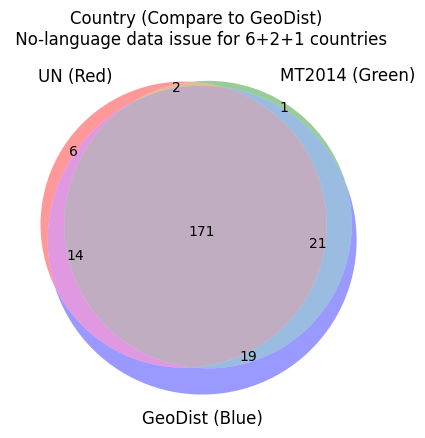

In [32]:
from matplotlib_venn import venn3
fig = venn3([set(un_country['iso3']), set(mt2014_country['iso3']), set(geo_country['iso3'])], set_labels=('UN (Red)','MT2014 (Green)','GeoDist (Blue)'))
plt.title('Country (Compare to GeoDist) \n No-language data issue for 6+2+1 countries')

In [33]:
#MT2014かつGeoDistでない
pd.merge(mt2014_country, geo_country, on='iso3', how='outer', indicator=True).query(f'_merge == "left_only"').drop(columns=['country_y', '_merge']).rename(columns={'country_x': 'country'}).reset_index(drop=True)

,iso3,country
0,BLX,Belgium and Luxembourg
1,COD,Democratic Republic of the Congo
2,ROU,Romania


In [34]:
#UNかつGeoDistではない
pd.merge(un_country, geo_country, on='iso3', how='outer', indicator=True).query(f'_merge == "left_only"').drop(columns=['country_y', '_merge']).rename(columns={'country_x': 'country'}).reset_index(drop=True)

,iso3,country
0,COD,Democratic Republic of the Congo
1,LIE,Liechtenstein
2,MCO,Monaco
3,MNE,Montenegro
4,ROU,Romania
5,SRB,Serbia
6,SSD,South Sudan
7,TLS,Timor-Leste


Text(0.5, 1.0, 'Country (Compare to Language) \n {MT2014} = {Language}')

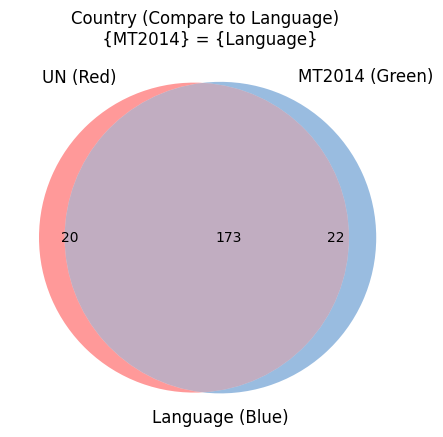

In [35]:
from matplotlib_venn import venn3
fig = venn3([set(un_country['iso3']), set(mt2014_country['iso3']), set(lingweb_country['iso3'])], set_labels=('UN (Red)','MT2014 (Green)','Language (Blue)'))
plt.title('Country (Compare to Language) \n {MT2014} = {Language}')

In [36]:
#国名コードをisoに合わせる
geo.loc[geo['iso3']=='ZAR','iso3'] = 'COD' #ZAR to COD (Democratic Republic of the Congo)
geo.loc[geo['iso3']=='ROM','iso3'] = 'ROU' #ROM to ROU (Romania)

In [37]:
#UN加盟国または先行研究で分析対象となっていた国のうち、GeoDistに載っていない国のデータを、CIA World Factbookをもとに加える
geo.loc['a'] = ['LIE', 'Liechtenstein', 'German']
geo.loc['b'] = ['MCO', 'Monaco', 'French']
geo.loc['c'] = ['MNE', 'Montenegro', 'Serbian']
geo.loc['d'] = ['SRB', 'Serbia', 'Serbian']
geo.loc['e'] = ['SSD', 'South Sudan', 'English']
geo.loc['f'] = ['TLS', 'Timor-Leste', 'Tetum']
geo.loc['g'] = ['BLX', 'Belgium and Luxembourg', 'Dutch']

Text(0.5, 1.0, 'Country (Compare to Gravity) \n No-trade data issue for 1+7+2 countries')

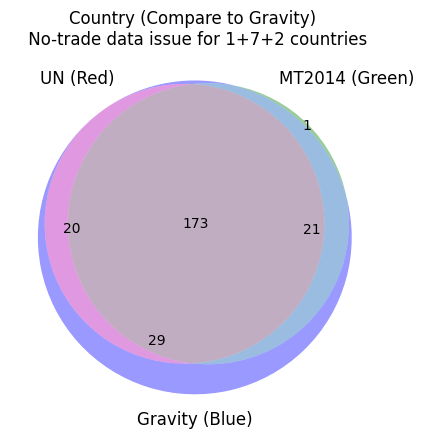

In [38]:
from matplotlib_venn import venn3
fig = venn3([set(un_country['iso3']), set(mt2014_country['iso3']), set(gravity_country['iso3'])], set_labels=('UN (Red)','MT2014 (Green)','Gravity (Blue)'))
plt.title('Country (Compare to Gravity) \n No-trade data issue for 1+7+2 countries')

In [39]:
#MT2014かつGravityでない
pd.merge(mt2014_country, gravity_country, on='iso3', how='outer', indicator=True).query(f'_merge == "left_only"').drop(columns=['country_y', '_merge']).rename(columns={'country_x': 'country'}).reset_index(drop=True)

,iso3,country,country_id
0,BLX,Belgium and Luxembourg,NaN


In [40]:
#UNかつGravityではない
pd.merge(un_country, gravity_country, on='iso3', how='outer', indicator=True).query(f'_merge == "left_only"').drop(columns=['country_y', '_merge']).rename(columns={'country_x': 'country'}).reset_index(drop=True)

,iso3,country,country_id


In [41]:
#分析で用いる国の集合（iso, country, language）を作成
country = mt2014_country
country = pd.merge(country, geo, on=['iso3'], how='left').drop(columns='country_y').rename(columns={'country_x':'country'})

In [42]:
#国連加盟国ダミー
country['un_member'] = country['iso3'].isin(un_country['iso3']).astype(int)

In [43]:
#貿易国のどちらかが1948から2020までの間に存在しない時期があった国のリストに存在する場合は1となる変数を作成
terrchange = ['YUG','SRB','MNE','SVN','SCG','MKD','HRV','BIH','YMD','YEM','UZB','UKR','TKM','TJK','SUN','RUS','MDA','LVA','LTU','KGZ','KAZ','GEO','EST','BLR','AZE','ARM','SSD','SDN','VNM','VDR','PAK','BGD','SXM','ANT','ABW','SGP','MYS','MYS','TLS','IDN','DEU','DDR','ETH','ERI','SVK','CZE','CSK']
country['terrchange'] = (country['iso3'].isin(terrchange)).astype(int)

In [44]:
country.head()

,iso3,country,langoff,un_member,terrchange
0,ABW,Aruba,Dutch,0,1
1,AFG,Afghanistan,Persian,1,0
2,AGO,Angola,Portuguese,1,0
3,AIA,Anguilla,English,0,0
4,ALB,Albania,Albanian,1,0


In [45]:
#langoffが欠損値となる国がないことを確認
country[country['langoff']!=country['langoff']]

,iso3,country,langoff,un_member,terrchange


In [46]:
years = pd.DataFrame(range(1950, 2021), columns=['year'])

In [47]:
data = pd.merge(country, country, how='cross', suffixes=['_o', '_d'])

In [48]:
len(data)

38025

In [49]:
data = pd.merge(years, data, how='cross').query('country_o != country_d').sort_values(['country_o', 'country_d', 'year']).reset_index(drop=True)

In [50]:
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,terrchange_d
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,0
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,0
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,0
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,0
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,0


In [51]:
len(data)

2685930

In [52]:
#Tradeデータを結合
data = pd.merge(data, gravity, on=['year','iso3_o','iso3_d'], how='left', indicator=True)
data = data[data['_merge'] != 'right_only'].drop(columns='_merge')
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,country_id_d,tradeflow_comtrade_o,tradeflow_baci,tradeflow_imf_o,dist,contig,col_dep_ever,comcol,comrelig,comleg_posttrans
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,ALB,0.0,0.0,0.0,4345.0,0.0,0.0,0.0,0.203565,1.0
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,ALB,0.0,0.0,0.0,4345.0,0.0,0.0,0.0,0.203565,1.0
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,ALB,0.0,0.0,0.0,4345.0,0.0,0.0,0.0,0.203565,1.0
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,ALB,0.0,0.0,0.0,4345.0,0.0,0.0,0.0,0.203565,1.0
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,ALB,0.0,0.0,0.0,4345.0,0.0,0.0,0.0,0.203565,1.0


In [53]:
set(data['country_o']) == set(lingweb['country_o'])

True

In [54]:
set(data['iso3_o']) == set(lingweb['iso_o'])

True

In [55]:
#Language変数を結合
data = pd.merge(data, lingweb, left_on=['iso3_o','country_o','iso3_d','country_d'], right_on=['iso_o','country_o','iso_d','country_d'], how='left', indicator=True)
data = data[data['_merge'] != 'right_only'].drop(columns=['iso_o','iso_d','_merge'])
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,dist,contig,col_dep_ever,comcol,comrelig,comleg_posttrans,col,csl,cnl,lp1
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,4345.0,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,4345.0,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,4345.0,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,4345.0,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,4345.0,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN


In [56]:
#COLを手動で作成
data['col1'] = (data['langoff_o']==data['langoff_d']).astype(int)

In [57]:
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,contig,col_dep_ever,comcol,comrelig,comleg_posttrans,col,csl,cnl,lp1,col1
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.0,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0


3.   Calculate linguistic proximity (Phonetics)

In [58]:
#GeoDistで使われている言語リストを作成
lan_list = sorted(list(set(country['langoff'])))

In [59]:
#言語数
n = len(lan_list)
n

61

In [60]:
#(n*8*22)の3次元配列(ndarray)を作成
all_c = np.zeros((n,8,22))

In [61]:
#第1ベクトルが言語別、第2・3ベクトルが音声記号行列となるように、発音データを割りあてる
for i, lan in enumerate(lan_list):
  try:
    all_c[i] = np.loadtxt(path_ipa + f'/{lan}_consonant.csv', delimiter = ',', encoding='utf-8-sig')
  except Exception as e:
    print(e)

In [62]:
all_c[2::]

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 1., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[1., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [63]:
#距離行列をつくるために、n行n列の0行列を作成(n=言語数)
dist = pd.DataFrame(np.zeros((n, n)), index = lan_list, columns = lan_list)

In [64]:
#行列のi行j列に、言語iと言語jとの距離（ノルム）を当てはめる（距離行列）
for row, lan1 in enumerate(lan_list):
  for col, lan2 in enumerate(lan_list):
    dist.at[lan1, lan2] = np.linalg.norm(all_c[col] - all_c[row], ord='fro')

In [65]:
#Proximityを計算
prox = 1 - (dist / dist.max().max())

In [66]:
for num in range(8):
  exec(f'dist_{num} = pd.DataFrame(np.zeros((n, n)), index = lan_list, columns = lan_list)')
  for row, lan1 in enumerate(lan_list):
    for col, lan2 in enumerate(lan_list):
      exec(f'dist_{num}.at[lan1, lan2] = np.linalg.norm(all_c[col,num] - all_c[row,num], ord=2)')
  exec(f'prox_{num} = 1 - (dist_{num} / dist_{num}.max().max())')

In [67]:
dist.head()

,Albanian,Arabic,Armenian,Azeri,Belarussian,Bengali,Bulgarian,Burmese,Catalan,Chinese,...,Tajik,Thai,Tongan,Turkish,Turkmen,Tuvaluan,Ukrainian,Urdu,Uzbek,Vietnamese
Albanian,0.000000,4.123106,3.605551,3.872983,3.872983,4.582576,3.872983,4.123106,4.358899,4.358899,...,4.690416,3.605551,3.316625,4.242641,4.123106,3.464102,3.741657,4.472136,4.123106,4.000000
Arabic,4.123106,0.000000,3.741657,4.242641,3.741657,4.242641,3.741657,4.690416,3.741657,4.472136,...,4.358899,3.741657,4.242641,3.872983,3.464102,4.358899,3.872983,3.872983,3.741657,4.358899
Armenian,3.605551,3.741657,0.000000,2.449490,2.828427,4.000000,2.449490,4.472136,3.162278,3.162278,...,4.123106,3.162278,2.828427,3.316625,3.741657,2.645751,3.000000,3.605551,3.162278,3.316625
Azeri,3.872983,4.242641,2.449490,0.000000,2.449490,4.242641,2.828427,4.472136,3.741657,3.741657,...,4.582576,3.162278,2.828427,2.645751,4.000000,3.000000,3.316625,3.872983,2.828427,2.236068
Belarussian,3.872983,3.741657,2.828427,2.449490,0.000000,4.000000,2.000000,4.472136,3.162278,4.242641,...,4.123106,3.162278,3.464102,2.645751,3.741657,3.605551,2.645751,3.605551,2.000000,3.316625


In [68]:
dist_0.head()

,Albanian,Arabic,Armenian,Azeri,Belarussian,Bengali,Bulgarian,Burmese,Catalan,Chinese,...,Tajik,Thai,Tongan,Turkish,Turkmen,Tuvaluan,Ukrainian,Urdu,Uzbek,Vietnamese
Albanian,0.000000,2.828427,2.449490,2.449490,2.449490,3.000000,2.645751,1.414214,2.645751,2.449490,...,2.645751,2.449490,2.236068,2.828427,2.645751,2.449490,2.236068,3.000000,2.449490,2.645751
Arabic,2.828427,0.000000,2.449490,2.449490,1.414214,2.236068,1.732051,2.449490,1.732051,2.449490,...,2.236068,2.000000,2.236068,2.000000,1.732051,2.449490,2.236068,2.236068,1.414214,2.236068
Armenian,2.449490,2.449490,0.000000,1.414214,2.000000,2.236068,1.732051,2.449490,1.732051,0.000000,...,3.000000,2.000000,1.000000,2.449490,1.732051,0.000000,2.236068,2.236068,2.000000,1.732051
Azeri,2.449490,2.449490,1.414214,0.000000,2.000000,2.645751,2.236068,2.449490,2.236068,1.414214,...,3.000000,1.414214,1.000000,2.000000,2.236068,1.414214,2.645751,2.645751,2.000000,1.000000
Belarussian,2.449490,1.414214,2.000000,2.000000,0.000000,1.732051,1.000000,2.000000,1.000000,2.000000,...,2.236068,1.414214,1.732051,1.414214,1.000000,2.000000,1.732051,1.732051,0.000000,2.236068


In [69]:
prox.head()

,Albanian,Arabic,Armenian,Azeri,Belarussian,Bengali,Bulgarian,Burmese,Catalan,Chinese,...,Tajik,Thai,Tongan,Turkish,Turkmen,Tuvaluan,Ukrainian,Urdu,Uzbek,Vietnamese
Albanian,1.000000,0.259468,0.352424,0.304392,0.304392,0.176945,0.304392,0.259468,0.217119,0.217119,...,0.157576,0.352424,0.404317,0.237999,0.259468,0.377829,0.327978,0.196781,0.259468,0.281579
Arabic,0.259468,1.000000,0.327978,0.237999,0.327978,0.237999,0.327978,0.157576,0.327978,0.196781,...,0.217119,0.327978,0.237999,0.304392,0.377829,0.217119,0.304392,0.304392,0.327978,0.217119
Armenian,0.352424,0.327978,1.000000,0.560059,0.491999,0.281579,0.560059,0.196781,0.432038,0.432038,...,0.259468,0.432038,0.491999,0.404317,0.327978,0.524809,0.461184,0.352424,0.432038,0.404317
Azeri,0.304392,0.237999,0.560059,1.000000,0.560059,0.237999,0.491999,0.196781,0.327978,0.327978,...,0.176945,0.432038,0.491999,0.524809,0.281579,0.461184,0.404317,0.304392,0.491999,0.598390
Belarussian,0.304392,0.327978,0.491999,0.560059,1.000000,0.281579,0.640789,0.196781,0.432038,0.237999,...,0.259468,0.432038,0.377829,0.524809,0.327978,0.352424,0.524809,0.352424,0.640789,0.404317


In [70]:
#dist.to_csv('dist_c.csv')

In [71]:
#言語のペアを作成（順列P(n, 2)の長さ）
lan_pairs = list(itertools.permutations(lan_list, 2))

In [72]:
lan_pairs[:5]

[('Albanian', 'Arabic'),
 ('Albanian', 'Armenian'),
 ('Albanian', 'Azeri'),
 ('Albanian', 'Belarussian'),
 ('Albanian', 'Bengali')]

In [73]:
len(lan_pairs)

3660

In [74]:
#データタイプをDataFrameに変更
lan_data = pd.DataFrame(lan_pairs)

In [75]:
#2言語の距離を割り当て
for i, pair in enumerate(lan_pairs):
  lan_data.loc[i,'lpc'] = prox.loc[pair[0], pair[1]]

In [76]:
for i, pair in enumerate(lan_pairs):
  for num in range(8):
    exec(f"lan_data.at[i,'lpc_{num+1}'] = prox_{num}.at[pair[0], pair[1]]")

In [77]:
lan_data = lan_data.rename(columns={0:'lan_o',1:'lan_d'})

In [78]:
lan_data['lpc_mean'] = lan_data.loc[:,'lpc_1':'lpc_8'].mean(axis=1)

In [79]:
#lpcとlpc_meanの相関係数
pg.corr(lan_data['lpc'], lan_data['lpc_mean'])

,n,r,CI95%,p-val,BF10,power
pearson,3660,0.808064,"[0.8, 0.82]",0.0,inf,1.0


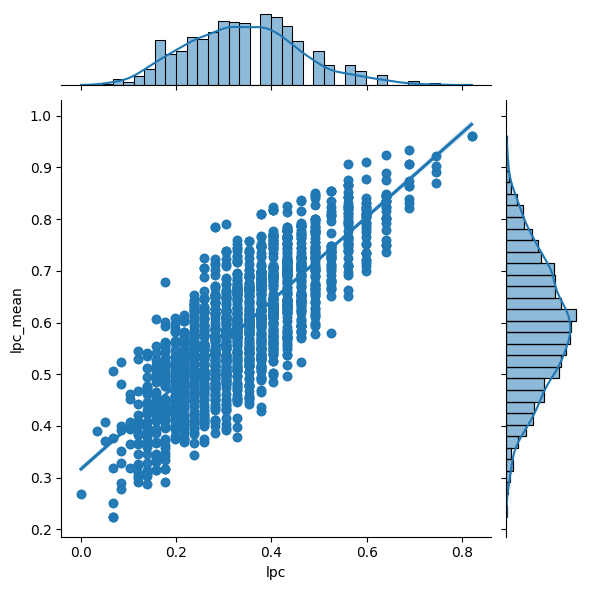

In [80]:
fig = sns.jointplot(x='lpc', y='lpc_mean', data=lan_data, kind="reg")

In [81]:
lan_data.head()

,lan_o,lan_d,lpc,lpc_1,lpc_2,lpc_3,lpc_4,lpc_5,lpc_6,lpc_7,lpc_8,lpc_mean
0,Albanian,Arabic,0.259468,0.215535,1.000000,1.0,0.422650,0.345346,NaN,0.183503,1.0,0.595291
1,Albanian,Armenian,0.352424,0.320634,1.000000,1.0,1.000000,0.402386,NaN,0.183503,1.0,0.700932
2,Albanian,Azeri,0.304392,0.320634,1.000000,0.5,1.000000,0.345346,NaN,0.183503,1.0,0.621355
3,Albanian,Belarussian,0.304392,0.320634,1.000000,1.0,1.000000,0.345346,NaN,0.183503,0.5,0.621355
4,Albanian,Bengali,0.176945,0.167950,0.591752,0.5,0.183503,0.345346,NaN,0.183503,1.0,0.424579


In [82]:
#LP変数を結合
data = pd.merge(data, lan_data, left_on=['langoff_o','langoff_d'], right_on=['lan_o','lan_d'], how='left', indicator=True)
data = data[data['_merge'] != 'right_only'].drop(columns=['_merge','lan_o','lan_d','lpc_1','lpc_2','lpc_3','lpc_4','lpc_5','lpc_6','lpc_7','lpc_8'])
data.loc[data['langoff_o']==data['langoff_d'], ['lpc','lpc_mean']] = 1
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,comcol,comrelig,comleg_posttrans,col,csl,cnl,lp1,col1,lpc,lpc_mean
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.0,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156


History of wars

In [83]:
cow.head()

,WarNum,WarName,StateName,Side,StartYear
0,1,Franco-Spanish War,Spain,2,1823
1,1,Franco-Spanish War,France,1,1823
2,4,First Russo-Turkish,Ottoman Empire,2,1828
3,4,First Russo-Turkish,Russia,1,1828
4,7,Mexican-American,Mexico,2,1846


In [84]:
#国名をcountryに合わせる
cow.StateName = cow.StateName.replace('Ottoman Empire','Turkey')
cow.StateName = cow.StateName.replace(['Tuscany','Modena','Two Sicilies','Papal States','Sardinia/Piedmont'],'Italy')
cow.StateName = cow.StateName.replace(['Prussia','Hesse Grand Ducal','Wuerttemburg','Bavaria','Mecklenburg Schwerin','Hesse Electoral','Saxony','Baden','Hanover'],'Germany')
cow.StateName = cow.StateName.replace('Austria-Hungary','Austria')
cow.StateName = cow.StateName.replace('Yemen Arab Republic','Yemen')
cow.StateName = cow.StateName.replace('China (PRC)','China')
cow.StateName = cow.StateName.replace('Taiwan (ROC)','Taiwan')
cow.StateName = cow.StateName.replace('Bosnia','Bosnia and Herzegovina')
cow.StateName = cow.StateName.replace(['USSR','Russia'],'Russian Federation')
cow.StateName = cow.StateName.replace('Belgium','Belgium and Luxembourg')
cow.StateName = cow.StateName.replace('Bolivia','Bolivia (Plurinational State of)')
cow.StateName = cow.StateName.replace('Iran','Iran (Islamic Republic of)')
cow.StateName = cow.StateName.replace('Laos',"Lao People's Democratic Republic")
cow.StateName = cow.StateName.replace('Libya','Libyan Arab Jamahiriya')
cow.StateName = cow.StateName.replace('Mongolia','Libyan Arab Jamahiriya')
cow.StateName = cow.StateName.replace('South Korea','Republic of Korea')
cow.StateName = cow.StateName.replace('Syria','Syrian Arab Republic')
cow.StateName = cow.StateName.replace(['South Vietnam','Vietnam'],'Viet Nam')
cow.StateName = cow.StateName.replace('Tanzania','United Republic of Tanzania')
cow.StateName = cow.StateName.replace('United Kingdom','United Kingdom of Great Britain and Northern Ireland')

In [85]:
set(cow['StateName']) - set(country['country'])

{'Czechoslovakia', 'Ethiopia', 'North Korea', 'Yugoslavia'}

In [86]:
cow = pd.merge(cow, country, left_on='StateName', right_on='country', how='left')
cow = cow.drop('country', axis=1)

In [87]:
cow.head()

,WarNum,WarName,StateName,Side,StartYear,iso3,langoff,un_member,terrchange
0,1,Franco-Spanish War,Spain,2,1823,ESP,Spanish,1.0,0.0
1,1,Franco-Spanish War,France,1,1823,FRA,French,1.0,0.0
2,4,First Russo-Turkish,Turkey,2,1828,TUR,Turkish,1.0,0.0
3,4,First Russo-Turkish,Russian Federation,1,1828,RUS,Russian,1.0,1.0
4,7,Mexican-American,Mexico,2,1846,MEX,Spanish,1.0,0.0


In [88]:
cow_concat = pd.DataFrame(columns=['WarNum','StartYear','WarName','iso3_1','StateName_1','iso3_2','StateName_2'])

In [89]:
#データをBilateralに変更
for num in set(cow['WarNum']):
  exec(f"cow_{num}_1 = cow.loc[(cow['WarNum']=={num})&(cow['Side']==1)].reset_index(drop=True)")
  exec(f"cow_{num}_2 = cow.loc[(cow['WarNum']=={num})&(cow['Side']==2)].reset_index(drop=True).drop(['WarNum','WarName'], axis=1)")
  exec(f"cow_{num} = pd.merge(cow_{num}_1, cow_{num}_2, how='cross', suffixes=['_1', '_2'])")
  exec(f"cow_{num}['StartYear'] = np.where(cow_{num}['StartYear_1']>cow_{num}['StartYear_2'], cow_{num}['StartYear_1'], cow_{num}['StartYear_2'])")
  exec(f"cow_{num} = cow_{num}.drop(['Side_1','StartYear_1','Side_2','StartYear_2'], axis=1).reindex(columns=['WarNum','StartYear','WarName','iso3_1','StateName_1','iso3_2','StateName_2'])")
  exec(f"cow_concat = pd.concat([cow_concat, cow_{num}]).reset_index(drop=True)")

In [90]:
cow_concat = cow_concat.reindex(columns=['StartYear','iso3_1','iso3_2']).drop_duplicates(subset=['iso3_1','iso3_2']).reset_index(drop=True)

In [91]:
cow_concat.head()

,StartYear,iso3_1,iso3_2
0,1823,FRA,ESP
1,1828,RUS,TUR
2,1846,USA,MEX
3,1848,AUT,ITA
4,1848,DEU,DNK


In [92]:
#histwars変数の作成
data = pd.merge(data, cow_concat, left_on=['iso3_o', 'iso3_d'], right_on=['iso3_1', 'iso3_2'], how='left', indicator=True)
data = data[data['_merge'] != 'right_only'].drop(columns=['_merge']).reset_index(drop=True)

In [93]:
len(data)

2685930

In [94]:
data['histwars'] = 0
data.loc[data['year']>=data['StartYear'],'histwars'] = 1
data = data.drop(['iso3_1','iso3_2','StartYear'], axis=1)

In [95]:
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,comrelig,comleg_posttrans,col,csl,cnl,lp1,col1,lpc,lpc_mean,histwars
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,0.203565,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0


FDI

In [96]:
data = pd.merge(data, fdi, left_on=['year','iso3_o','iso3_d'], right_on=['Year','COU','PC'], how='left', indicator=True)
data = data[data['_merge'] != 'right_only'].drop(['Year','PC','Partner country','COU','Reporting country','Flag Codes','Flags','_merge'], axis=1)

In [111]:
data.head()

,year,iso3_o,country_o,langoff_o,un_member_o,terrchange_o,iso3_d,country_d,langoff_d,un_member_d,...,comleg_posttrans,col,csl,cnl,lp1,col1,lpc,lpc_mean,histwars,fdi
0,1950,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0,NaN
1,1951,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0,NaN
2,1952,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0,NaN
3,1953,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0,NaN
4,1954,AFG,Afghanistan,Persian,1,0,ALB,Albania,Albanian,1,...,1.0,NaN,NaN,NaN,NaN,0,0.327978,0.693156,0,NaN


In [97]:
len(lan_list)

61

In [98]:
len(country)

195

In [99]:
len(years)

71

In [100]:
len(country)*(len(country)-1)*len(years)

2685930

In [110]:
len(data)

2685930

In [103]:
set(data['country_o']) == set(country['country'])

True

In [112]:
#STATA形式でファイルを保存
data.to_stata('/content/drive/MyDrive/fujii/data/dataset.dta', write_index=False)

In [108]:
#csv形式でファイルを保存
#data.to_csv('/content/drive/MyDrive/fujii/data/dataset.csv', index=False)